In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 
import kinetics_simulator as ks
import numpy as np

In [46]:
# Define a reaction:

rxn = \
"""
A = 1000
B = 60
C = 20

A -> B; 1
B -> C; 5
C -> A; 0.1
"""

### Run the reaction as a deterministic Markov matrix

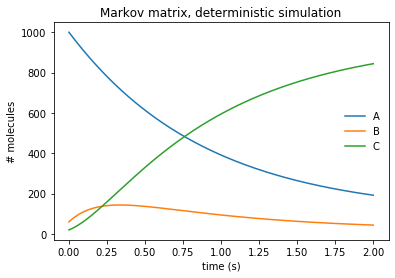

In [47]:
# create markov model, choosing dt such that p_self is 0.999
m = ks.MarkovModel(rxn,min_self_prob=0.999)

# run 10,000 time steps
for i in range(10000):
    m.take_step()

# Plot result
plt.plot(m.conc_history.time,m.conc_history.A,label="A")
plt.plot(m.conc_history.time,m.conc_history.B,label="B")
plt.plot(m.conc_history.time,m.conc_history.C,label="C")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("# molecules")
plt.title("Markov matrix, deterministic simulation")
None

### Run reaction as a stochastic Gillespie simulation

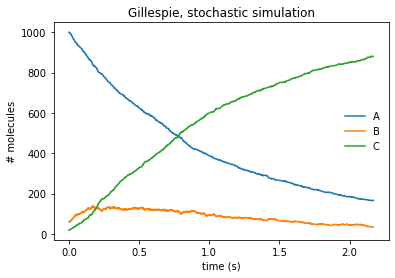

In [48]:
# create markov model
g = ks.Gillespie(rxn)

# Run 2,000 time steps (will correspond to ~2 seconds)
for i in range(2000):
    g.take_step()
    
# Plot result
plt.plot(g.conc_history.time,g.conc_history.A,label="A")
plt.plot(g.conc_history.time,g.conc_history.B,label="B")
plt.plot(g.conc_history.time,g.conc_history.C,label="C")
plt.legend(frameon=False)
plt.xlabel("time (s)")
plt.ylabel("# molecules")
plt.title("Gillespie, stochastic simulation")
None

### Compare stochastic and deterministic simulations

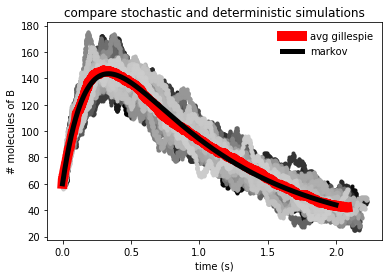

In [49]:
# Run num_reps replicate simulations
num_reps = 50
for i in range(num_reps):
    
    # Create new gillespie model and run for 2,000 steps
    g = ks.Gillespie(rxn)
    for j in range(2000):
        g.take_step()
    
    # Plot replicate result as gray line
    plt.plot(g.conc_history.time,g.conc_history.B,".",color="{}".format(0.8*(i+1)/num_reps))
    
    # Add to average output
    if i == 0:
        avg = np.copy(g.conc_history.B)
    else:
        avg += g.conc_history.B
    
# Finalize average and plot as a red line.
avg = avg/num_reps
plt.plot(g.conc_history.time,avg,"-",lw=10,color="red",label="avg gillespie")
    
# Plot markov model as a black line
plt.plot(m.conc_history.time,m.conc_history.B,"-",lw=5,color="black",label="markov")
plt.xlabel("time (s)")
plt.ylabel("# molecules of B")
plt.title("compare stochastic and deterministic simulations")
plt.legend(frameon=False)
None


### Create your own gillespie reaction below

+ Define all reactions in the rxn field as: 
    ```
    s1 + s2 -> s3; rate
    ...
    ```
+ Set initial concentrations of all species in the rxn field as: 
    ```
    s1 = 5
    s2 = 0
    s3 = 2
    ...
    ```
+ Alter the plot call to plot your species of interest:
    ```
    gplt.plot(g.conc_history.time,g.conc_history.XXX)
    ```
    becomes something like
    ```
    plt.plot(g.conc_history.time,g.conc_history.s1)
    ```

In [ ]:
rxn = \
"""
"""

# create markov model
g = ks.Gillespie(rxn)

# Run 2,000 time steps (will correspond to ~2 seconds)
for i in range(2000):
    g.take_step()
    
plt.plot(g.conc_history.time,g.conc_history.XXX)


### Construct the basic actin polymerization reaction

The code below code creates a `rxn` entry where:  
+ formation of up to trimers is slow (`k = 0.001`)
+ formation of tetramers and higher is fast (`k = 1.000`)
+ initial number of monomers is `10,000`
+ initial number of all other species is `0`
+ filaments of up to `200` subunits can form


In [80]:
rxn_lines =     ["A1 + A1 -> A2; 0.001"]
rxn_lines.append("A2 -> A1 + A1; 1.000")

rxn_lines.append("A1 + A2 -> A3; 0.001")
rxn_lines.append("A3 -> A2 + A1; 1.000")

rxn_lines.append("A1 = 1000")
rxn_lines.append("A2 = 0")

for i in range(3,150):
    rxn_lines.append("A1 + A{} -> A{}; 1.000".format(i,i+1))
    rxn_lines.append("A{} -> A1 + A{}; 0.001".format(i+1,i))
    rxn_lines.append("A{} = 0".format(i))
rxn_lines.append("A{} = 0".format(i+1))

rxn = "\n".join(rxn_lines)

print("\n".join(rxn_lines[:12]))
print("...")

A1 + A1 -> A2; 0.001
A2 -> A1 + A1; 1.000
A1 + A2 -> A3; 0.001
A3 -> A2 + A1; 1.000
A1 = 1000
A2 = 0
A1 + A3 -> A4; 1.000
A4 -> A1 + A3; 0.001
A3 = 0
A1 + A4 -> A5; 1.000
A5 -> A1 + A4; 0.001
A4 = 0
...


In [143]:
def plot_actin(history,invisible_species=("A1","A2","A3","A4","ARP"),time_scalar=3000):
 
    signal = []
    for c in history.columns:
        if c[0] != "A":
            signal.append(0)
        else:
            if c in invisible_species:
                signal.append(0)
            else:
                signal.append(float(c[1:].split("_")[0]))

    signal_vector = np.array(signal)
    
    final_signal = np.sum(signal_vector*history.iloc[:,:],1)
    plt.plot(history.time*time_scalar,final_signal,lw=2)
    plt.xlabel("time (s)")
    plt.ylabel("fluorescence")
            


In [144]:
mech1 = \
"""
DIP_ARP = 0
A2_ARP = 0
A1_DIP_ARP = 0
A2_DIP_ARP = 0
A3_DIP_ARP = 0

A2 + ARP -> A2_ARP; 1
A2_ARP + DIP -> A2_DIP_ARP; 1
A1 + A2_DIP_ARP -> A3_DIP_ARP; 1
A1 + A3_DIP_ARP -> A4; 1
"""

mech2 = \
"""
DIP_ARP = 0
A2_ARP = 0
A1_DIP_ARP = 0
A2_DIP_ARP = 0
A3_DIP_ARP = 0

DIP + ARP -> DIP_ARP; 1
A1 + DIP_ARP -> A1_DIP_ARP; 1
A1 + A1_DIP_ARP -> A2_DIP_ARP; 1  
A1 + A2_DIP_ARP -> A3_DIP_ARP; 1
A1 + A3_DIP_ARP -> A4; 1
"""

In [145]:
g = ks.Gillespie(rxn)
for i in range(1000):
    g.take_step()

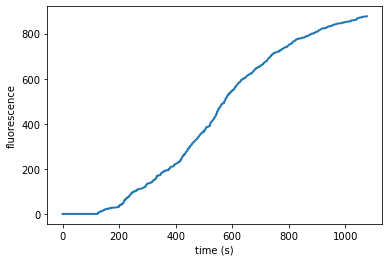

In [146]:
plot_actin(g.conc_history)

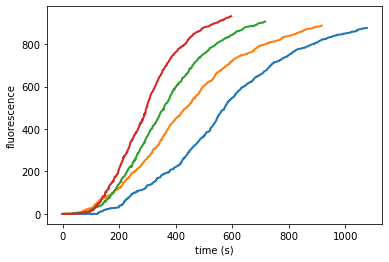

In [147]:
plot_actin(g.conc_history)

for c in [10,25,100]: 

    initial_conc = "DIP = {}\n ARP = 20\n".format(c)
    
    h = ks.Gillespie(rxn + mech1 + initial_conc)
    for i in range(1000):
        h.take_step()

    plot_actin(h.conc_history)

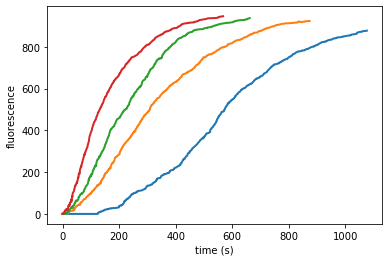

In [148]:
plot_actin(g.conc_history)

for c in [10,25,100]:

    initial_conc = "DIP = {}\n ARP = 20\n".format(c)
    
    h = ks.Gillespie(rxn + mech2 + initial_conc)
    for i in range(1000):
        h.take_step()

    plot_actin(h.conc_history)